### **Libraries**

In [1]:
from torch.distributions import Normal, Categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import deque
from datetime import datetime
import torch.optim as optim
from tqdm import trange
import pandas as pd, time
import gymnasium as gym
import torch.nn as nn
import numpy as np
import torch
import json
import os

In [2]:
os.makedirs("results", exist_ok=True)

### **Environments**

In [3]:
env_name = "Pendulum-v1"

### **Hyperparameters**

In [4]:
GAMMA = 0.99
LR = 3e-4
ENTROPY_COEF = 0.01
GAE_LAMBDA = 0.95
MAX_EPISODES = 20000
SEED = 42

In [5]:
np.random.seed(SEED)
torch.manual_seed(SEED)

In [6]:
def set_env_seed(env, seed=SEED):
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

def plot_rewards(reward_dict):
    plt.figure(figsize=(10,6))
    for key, rewards in reward_dict.items():
        plt.plot(rewards, label=key)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Algorithm Comparison")
    plt.legend()
    plt.grid()
    plt.show()

def plot_live(rewards, title):
    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(rewards, label='Reward')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend()
    plt.show()

### **REINFORCE policy (continuous)**

In [7]:
class PolicyREINFORCE(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(act_dim)) 

    def forward(self, x):
        mean = self.fc(x)
        std = torch.exp(self.log_std)
        return mean, std

### **A2C with separate networks**

In [ ]:
class ActorCriticSeparate(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()

        self.actor_fc = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(act_dim))

        self.critic_fc = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128,1)
        )
    
    def forward(self, x):
        mean = self.actor_fc(x)
        std = torch.exp(self.log_std)
        value = self.critic_fc(x)
        return (mean, std), value

### **A2C with shared network**

In [9]:
class ActorCriticShared(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU()
        )
        self.actor_head = nn.Linear(128, act_dim)
        self.log_std = nn.Parameter(torch.zeros(act_dim))
        self.critic_head = nn.Linear(128,1)
    
    def forward(self, x):
        feat = self.shared(x)
        mean = self.actor_head(feat)
        std = torch.exp(self.log_std)
        value = self.critic_head(feat)
        return (mean, std), value

### **REINFORCE Training Loop**

In [ ]:
def train_reinforce(env_name):

    env = gym.make(env_name)
    set_env_seed(env)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    policy = PolicyREINFORCE(obs_dim, act_dim)
    optimizer = optim.Adam(policy.parameters(), lr=LR)
    metrics_list = []

    progress = trange(MAX_EPISODES, desc="REINFORCE", ncols=100)
    for ep in progress:
        start_time = time.time()
        state, _ = env.reset()
        log_probs, rewards = [], []
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state)
            mean, std = policy(state_tensor)
            dist = torch.distributions.Normal(mean, std)
            action = dist.sample()
            next_state, reward, terminated, truncated, _ = env.step(action.detach().numpy())
            done = terminated or truncated

            log_probs.append(dist.log_prob(action).sum())
            rewards.append(reward)
            state = next_state

        # compute discounted returns
        G = 0
        returns = []
        for r in reversed(rewards):
            G = r + GAMMA * G
            returns.insert(0, G)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # policy gradient update
        loss = 0
        for log_prob, R in zip(log_probs, returns):
            loss -= log_prob * R
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ep_reward = sum(rewards)
        progress.set_postfix_str(f"Reward: {ep_reward:.2f}")

        episode_time = time.time() - start_time
        metrics_list.append({
            "episode": ep + 1,
            "reward": ep_reward,
            "time": episode_time
        })

    env.close()
    df = pd.DataFrame(metrics_list)
    return df

### **A2C Training Loop (separate/shared, with optional GAE)**

In [ ]:
def train_a2c(env_name, variant="separate", use_gae=False):
    env = gym.make(env_name)
    set_env_seed(env)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    if variant == "separate":
        model = ActorCriticSeparate(obs_dim, act_dim)
    else:
        model = ActorCriticShared(obs_dim, act_dim)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    metrics_list = []
    rewards_list = []

    progress = trange(MAX_EPISODES, desc=f"A2C-{variant}{'+GAE' if use_gae else ''}", ncols=100)
    for ep in progress:
        start_time = time.time()
        
        state, _ = env.reset()
        states, actions, rewards, log_probs, values, dones = [], [], [], [], [], []
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state)
            (mean, std), value = model(state_tensor)
            dist = torch.distributions.Normal(mean, std)
            action = dist.sample()

            next_state, reward, terminated, truncated, _ = env.step(action.detach().numpy())
            done = terminated or truncated

            states.append(state_tensor)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(dist.log_prob(action).sum())
            values.append(value)
            dones.append(done)

            state = next_state

        # advantages
        returns, advantages = [], []
        R, A = 0, 0
        values_tensor = torch.cat(values).squeeze().detach()
        for t in reversed(range(len(rewards))):
            mask = 1.0 - float(dones[t])
            if use_gae:
                delta = rewards[t] + GAMMA * (values_tensor[t+1] if t+1 < len(values_tensor) else 0) - values_tensor[t]
                A = delta + GAMMA * GAE_LAMBDA * mask * A
                advantages.insert(0, A)
            R = rewards[t] + GAMMA * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)
        advantages = torch.tensor(advantages if use_gae else returns - values_tensor, dtype=torch.float32)

        # loss
        values_pred = torch.cat(values).squeeze()
        actor_loss = -torch.stack([log_prob * adv for log_prob, adv in zip(log_probs, advantages)]).mean()
        critic_loss = ((returns - values_pred) ** 2).mean()
        loss = actor_loss + 0.5 * critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ep_reward = sum(rewards)
        progress.set_postfix_str(f"Reward: {ep_reward:.2f}")
        rewards_list.append(ep_reward)

        if (ep + 1) % 20 == 0: 
            plot_live(rewards_list, f"{env_name}-A2C-{variant}{'+GAE' if use_gae else ''}")

        episode_time = time.time() - start_time
        metrics_list.append({
            "episode": ep + 1,
            "reward": ep_reward,
            "time": episode_time
        })

    env.close()
    df = pd.DataFrame(metrics_list)
    return df

### **Clasicc Control Env**

In [12]:
results = {}
metrics = {
    "REINFORCE": {},
    "A2C_separate": {},
    "A2C_shared": {},
    "A2C_shared_GAE": {}
}

In [13]:
print(f"\n=== Training on: {env_name} ===")


=== Training on: Pendulum-v1 ===


In [ ]:
# REINFORCE 
df_reinforce = train_reinforce(env_name) 
metrics["REINFORCE"] = df_reinforce
df_reinforce.to_csv(f"results/REINFORCE_{env_name}.csv", index=False)

REINFORCE: 100%|█████████████████████████████| 20000/20000 [58:39<00:00,  5.68it/s, Reward: -872.89]


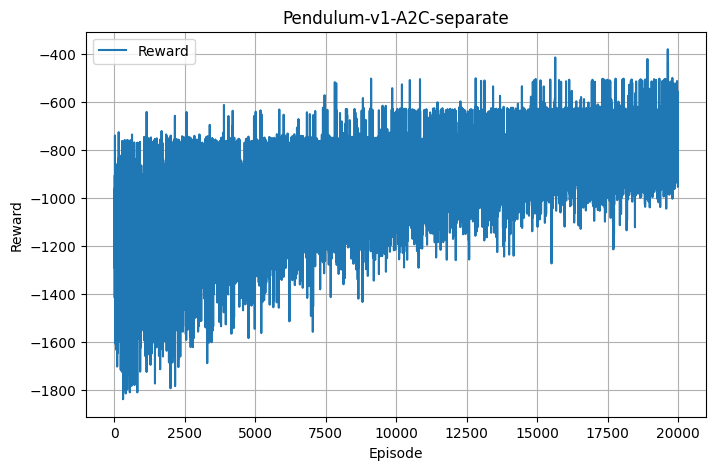

A2C-separate: 100%|████████████████████████| 20000/20000 [1:20:25<00:00,  4.15it/s, Reward: -776.43]


In [ ]:
# A2C Separate 
df_a2c_sep = train_a2c(env_name, variant="separate")
metrics["A2C_separate"] = df_a2c_sep
df_a2c_sep.to_csv(f"results/A2C_separate_{env_name}.csv", index=False)

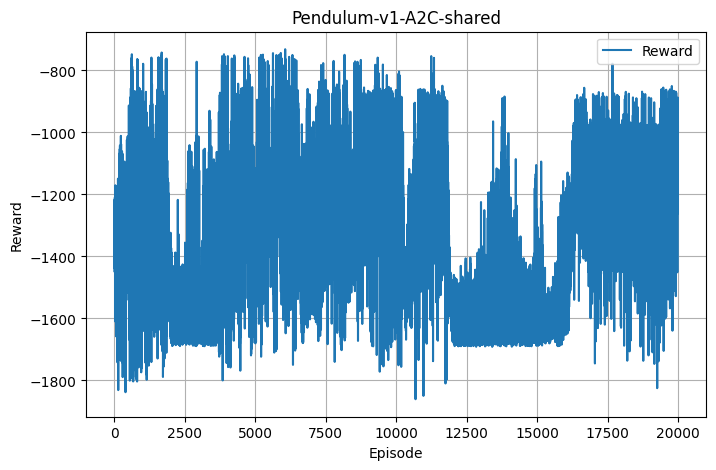

A2C-shared: 100%|██████████████████████████| 20000/20000 [1:11:31<00:00,  4.66it/s, Reward: -992.66]


In [ ]:
# A2C Shared 
df_a2c_shared = train_a2c(env_name, variant="shared")
metrics["A2C_shared"] = df_a2c_shared
df_a2c_shared.to_csv(f"results/A2C_shared_{env_name}.csv", index=False)

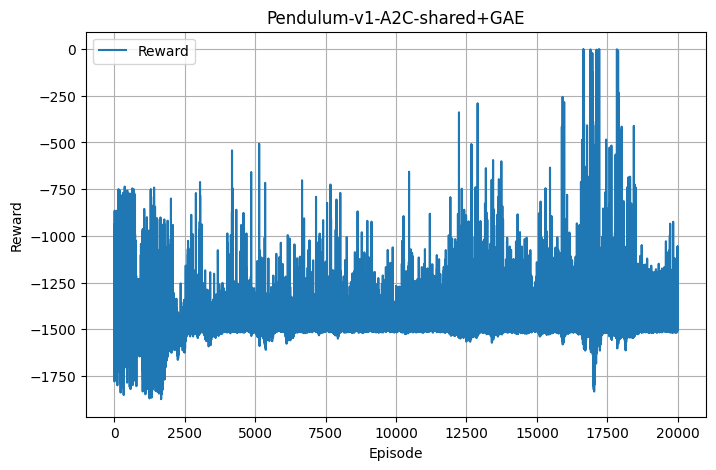

A2C-shared+GAE: 100%|█████████████████████| 20000/20000 [1:15:04<00:00,  4.44it/s, Reward: -1482.34]


In [ ]:
# A2C Shared + GAE 
df_a2c_shared_gae = train_a2c(env_name, variant="shared", use_gae=True)
metrics["A2C_shared_GAE"] = df_a2c_shared_gae
df_a2c_shared_gae.to_csv(f"results/A2C_shared_GAE_{env_name}.csv", index=False)

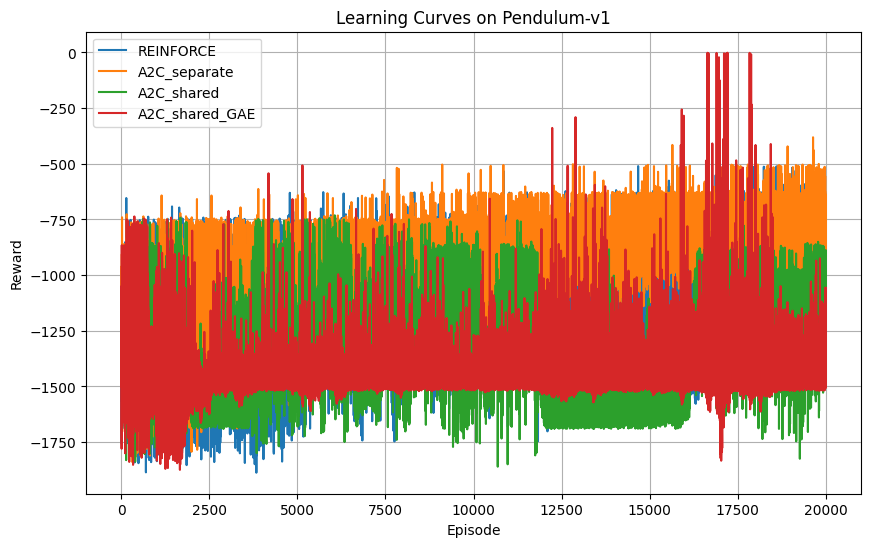

In [ ]:
plt.figure(figsize=(10,6))

for algo in ["REINFORCE", "A2C_separate", "A2C_shared", "A2C_shared_GAE"]:
    df = metrics[algo]
    plt.plot(df['episode'], df['reward'], label=algo)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Learning Curves on {env_name}")
plt.legend()
plt.grid(True)
plt.show()